<a href="https://colab.research.google.com/github/TK-Problem/Python-mokymai/blob/master/Scripts/bdtechtalks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Importuoti paketus
#@markdown Paketų atsisiuntimas gali užtrunkti beveik 2 minutes.
%%time
# playwright biblioteka naudojama importuoti html kodą
# įrašyti specifinę versiją, kad veiktų ant google colab
!pip install playwright==1.25.00
!playwright install-deps
!playwright install webkit
!pip install nest_asyncio

# playwright veikia TIK asyncio režimu naudojant google colab
import nest_asyncio
nest_asyncio.apply()
import asyncio

# importuoti playwright versiją
from playwright.async_api import async_playwright

# bs4 naudojama iš HTML ištraukti reikiamą informaciją
from bs4 import BeautifulSoup

# reikalingas paskaičiuoti, kiek užtrunka programos veikimas
import time

# paketai dirbti su skaičiais ir duomenimis
import pandas as pd
import numpy as np

# biblioteka skirta sugeneruoti žodžių debesiui
from wordcloud import WordCloud

# stacionarūs paveiksliukai
import matplotlib.pyplot as plt

# clear output komanda naudojama išvalyti informacijai
from IPython.display import clear_output
clear_output()

CPU times: user 870 ms, sys: 91.1 ms, total: 961 ms
Wall time: 30.3 s


#  Duomenų atsisiuntimas

Pagrindiniai `TechTalk` funkcijos veikimo žingsniai (kodas kitoje celėje):

1. sukuria `playwright` webdriver'į (webkit),
2. sukuria netikrą `user_agent`, kad svetainė tave laikytų tikru varotoju,
3. nueina į puslapį,
4. paspaudžia ant cookie mygtuko,
5. penkis kartus su pelės ratuku eina į puslapio apačią (greitas bet neefektyvus būdas sulaukti "load more" mygtuko),
6. laukia kol atsiras mygtukas "load more" ir spaudžia žemyn,
7. nuskaito HTML kodą iš išsaugo į BS4 elementą,
8. iš nuskaityto HTML kodo ištraukiama reikalinga informaciją į list'ą,
9. duomenis yra išsaugomi ir gražinami pandas DataFrame formatu.

Pagrindinis šio script'o tikslas nuskaityti duomenis iš puslapio su "infinite scroll" funkcija.

In [2]:
#@title `TechTalk` funkcijos kodas
async def TechTalk():
    """
    This function returns all blog titles.
    Output:
      returns pandas DataFrame
    """
    async with async_playwright() as p:

        # 1. create webdriver/webkit
        browser = await p.webkit.launch()

        # 2. create user agent for the webdriver
        user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:95.0) Gecko/20100101 Firefox/95.0'

        # create new page, i.e. new table in your browser
        page = await browser.new_page(user_agent=user_agent)

        # 3. generate URL with a keyword
        url = f"https://bdtechtalks.com/category/blog/"

        # visit page
        await page.goto(url)

        # 4. click cookie button
        await page.click("//a[@id='cookie_action_close_header']")

        # implicit wait
        time.sleep(2)

        # 5. page.mouse.wheel(horizontally, vertically(positive is
        # scrolling down, negative is scrolling up)
        # https://stackoverflow.com/questions/69183922/playwright-auto-scroll-to-bottom-of-infinite-scroll-page
        for i in range(5):
          # make the range as long as needed
          await page.mouse.wheel(0, 15000)

          # wait till page loads
          time.sleep(2)

          # temp. screen shots to monitor progress
          await page.screenshot(path=f"{str(i).zfill(3)}.png")

        # record start time
        script_start_time = time.time()

        # 6. check if button is visible
        while await page.locator("text=Load more").is_visible():
          # click load more buton
          await page.locator("text=Load more").click()

          # wait till page loads
          time.sleep(2)

          # scroll down
          await page.mouse.wheel(0, 15000)
          i += 1

          # take status screen shot (uncomment for debuging)
          # await page.screenshot(path=f"{str(i).zfill(3)}.png")

          if (i + 5) % 20 == 0:

            # print status message
            print(f"{(i + 5)} pages loaded. Script is running for {time.time() - script_start_time:.1f} secs.")

          if i > 200:
            break

        # get page html contents
        page_source = await page.content()

        # 7. convert to bs4 object
        soup = BeautifulSoup(page_source, "lxml")

        # article blocks
        blocks = soup.findAll('div', {'class': 'td-item-details'})

        # tmp list to store data
        lst = list()

        # 8. iterate over all blocks to extract relavant data
        for block in blocks:
          # get article title
          _title = block.find('a', {'rel': 'bookmark'})

          # article author
          _author = block.find('span', {'class': 'td-post-author-name'}).text

          # url to an article
          _url = _title['href']

          # short description/headline
          _desc = block.find('div', {'class': 'td-excerpt'}).text

          # add to list
          lst.append([_title.text, _author, _url, _desc])

        # save image to your enviroment (for debuging)
        # one can comment this line
        await page.screenshot(path="last_status.png")

        # close webkit
        await browser.close()

        # 9. create and return pandas DataFrame
        df = pd.DataFrame(lst, columns = ['Title', 'Author', 'URL', 'Excerpt'])
        return df

In [3]:
%%time
#@title Atsisiųsti duomenis

# iškviečiame funkciją ir išsaugome duomenis ir atvaizduojame pirmus 5 skelbimus
df = asyncio.run(TechTalk())

# sutvarkyti antrašes, nuimti '\n' simbolius
df.Excerpt = df.Excerpt.str.strip()

# parašyti kiek rado skelbimų
print(f"{len(df)} articles found.")

df.head()

20 pages loaded. Script is running for 27.8 secs.
40 pages loaded. Script is running for 80.3 secs.
60 pages loaded. Script is running for 137.3 secs.
683 articles found.
CPU times: user 12.3 s, sys: 430 ms, total: 12.7 s
Wall time: 3min 32s


,Title,Author,URL,Excerpt
0,"LLMs can’t self-correct in reasoning tasks, De...",Ben Dickson,https://bdtechtalks.com/2023/10/09/llm-self-co...,A study by Google's DeepMind and the Universit...
1,Can AI be a force for social good?,Contributor,https://bdtechtalks.com/2023/10/06/ai-for-soci...,Will AI's potential benefits outweigh its poss...
2,This generative AI model can be a big deal for...,Ben Dickson,https://bdtechtalks.com/2023/10/02/syncdreamer...,"SyncDreamer, a new diffusion model, uses gener..."
3,The promising alliance of generative and discr...,Contributor,https://bdtechtalks.com/2023/09/29/generative-...,While the applications for generative AI conti...
4,What to know about Amazon’s Alexa LLM,Ben Dickson,https://bdtechtalks.com/2023/09/25/alexa-llm/,Amazon is officially in the commercial languag...


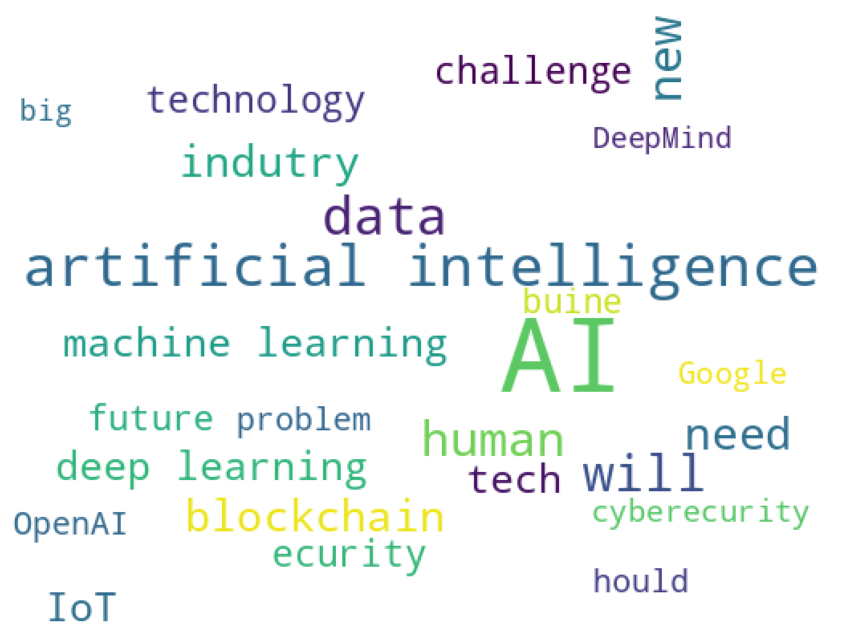

In [4]:
#@title Žodžių debesis

#@markdown Duomenų atvaizdavimas su wordcloud funcija.

# select maximum number for genrating word cloud figure
max_words = 25  # @param {type: "slider", min: 10, max: 100}

# generate word cloud
wordcloud = WordCloud(background_color = 'white',
                      width = 512,
                      height = 384,
                      max_words = max_words).generate(" ".join(df.Title).replace("s", ''))

# create figure object for word cloud
plt.subplots(figsize = (16,8))
plt.imshow(wordcloud) # image show
plt.axis('off'); # to off the axis of x and y

# Išsaugoti duomenis

Norint atsisiųsti duomenis lokaliai paspauskite ant dešinėje pusė esančios "Files" ikonos ir atsisiųskite norimą failą. Jei to nepadarysite, failai bus ištrinti uždarius google colab.

![image info](https://i.stack.imgur.com/mYWnb.png)

In [5]:
#@title Kodo pavyzdžiai
#@markdown išsaugoti `xlsx` arba `.csv` formatu.

# numimti komentarus nuo kodo eilučių
# excel
# df.to_excel(f"techtalk.xlsx", index = False)
# .csv
# df.to_csv(f"techtalk.csv", index = False)